In [183]:
import os
import numpy as np 
import matplotlib.pylab as plt 
import torch 
import torch.nn as nn
import flowtorch.bijectors as bij
import flowtorch.distributions as dist
import flowtorch.parameters as params
from getdist import plots, MCSamples
import getdist
import emcee 
import scipy.stats as ss 
from matplotlib import cm
import tqdm 
import random

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 20
settings={'mult_bias_correction_order':0,'smooth_scale_2D':0.3, 'smooth_scale_1D':0.3}

color1 = cm.tab10.colors[0]
color2 = cm.tab10.colors[1]
color3 = cm.tab10.colors[2]
color4 = cm.tab10.colors[3]
color5 = cm.tab10.colors[4]
color6 = cm.tab10.colors[5]

nsamples = 10000
nwalkers = 12

## Gaussian Linear Model

In [184]:
def logprior(theta):
    ntheta = len(theta)
    identity = np.identity(ntheta)
    dist = ss.multivariate_normal(np.zeros(ntheta), identity)
    return dist.logpdf(theta)

def linear_model(parameters, xvalues):
    return parameters[0] * xvalues + parameters[1]
    
def linear_loglike(theta, xvalues, data, sigma):
    theory = linear_model(theta, xvalues)
    diff = data - theory 
    chi2 = np.sum((diff/sigma)**2)
    return -0.5*chi2

def linear_logpost(theta, xvalues, data, sigma):
    logl = linear_loglike(theta, xvalues, data, sigma)
    logp = logprior(theta)
    return logl + logp

class GaussianLinearClass:
    def __init__(self, truth, sigma=1.0, ndata=100, xmin = 0.0, xmax = 1.0):
        self.xvalues = np.linspace(xmin, xmax, ndata)
        self.ndata = ndata
        self.sigma = sigma
        self.truth_gl = truth
        self.ndim = len(truth)
        self.data_gl = linear_model(truth, self.xvalues) + np.random.normal(0, self.sigma, self.ndata)

    def gl_sampler(self, nsamples, nwalkers = 4, eps = 1E-3):
        pos = self.truth_gl + eps * np.random.randn(nwalkers, self.ndim)
        nwalkers, ndim = pos.shape
        sampler = emcee.EnsembleSampler(nwalkers, ndim, linear_logpost, args=(self.xvalues, self.data_gl, self.sigma))
        sampler.run_mcmc(pos, nsamples, progress=True);
        return sampler

## Banana Posterior

In [185]:
def banana_model(parameters):
    return parameters[0] + 0.1 * parameters[1]**2
    
def banana_loglike(theta,  data, sigma):
    theory = banana_model(theta)
    diff = data - theory 
    chi2 = np.sum((diff/sigma)**2)
    return -0.5*chi2

def banana_logpost(theta, data, sigma):
    logl = banana_loglike(theta, data, sigma)
    logp = logprior(theta)
    return logl + logp

class BananaClass:
    def __init__(self, truth, sigma=1.0, ndata = 100):
        self.ndata = ndata
        self.sigma = sigma
        self.truth_bn = truth
        self.ndim = len(truth)
        self.data_bn = banana_model(truth) + np.random.normal(0, self.sigma, self.ndata)

    def banana_sampler(self, nsamples, nwalkers = 4, eps = 1E-3):
        pos = self.truth_bn + eps * np.random.randn(nwalkers, self.ndim)
        nwalkers, ndim = pos.shape
        sampler = emcee.EnsembleSampler(nwalkers, ndim, banana_logpost, args=(self.data_bn, self.sigma))
        sampler.run_mcmc(pos, nsamples, progress=True);
        return sampler

In [186]:
def joint_loglike(theta, data_gl, data_bn, xvalues, sigma):
    loglike_gl = linear_loglike(theta, xvalues, data_gl, sigma)
    loglike_bn = banana_loglike(theta,  data_bn, sigma)
    return loglike_gl + loglike_bn

def joint_logpost(theta, data_gl, data_bn, xvalues, sigma):
    logl = joint_loglike(theta, data_gl, data_bn, xvalues, sigma)
    logp = logprior(theta)
    return logl + logp

class JointSampler(GaussianLinearClass, BananaClass):
    def __init__(self, truth_gl, truth_bn, sigma=1.0, ndata=100, xmin = 0.0, xmax = 1.0):
        self.initial = 0.5*(truth_gl + truth_bn)
        GaussianLinearClass.__init__(self, truth_gl, sigma, ndata, xmin, xmax)
        BananaClass.__init__(self, truth_bn, sigma, ndata)

    def joint_sampler(self, nsamples, nwalkers = 4, eps = 1E-3):
        pos = self.initial + eps * np.random.randn(nwalkers, self.ndim)
        nwalkers, ndim = pos.shape
        sampler = emcee.EnsembleSampler(nwalkers, ndim, joint_logpost, args=(self.data_gl, self.data_bn, self.xvalues, self.sigma))
        sampler.run_mcmc(pos, nsamples, progress=True);
        return sampler

In [202]:
truth_gl = np.array([2.0, 0.25])
truth_bn = np.array([0.25, 0.25])

# GLmodule = GaussianLinearClass(truth)
# GLsampler = GLmodule.gl_sampler(10000, nwalkers = 12)

# banana_module = BananaClass(truth)
# banana_sampler = banana_module.banana_sampler(10000, nwalkers = 12)

module = JointSampler(truth_gl, truth_bn)

In [203]:
sampler_gl = module.gl_sampler(nsamples, nwalkers)
sampler_banana = module.banana_sampler(nsamples, nwalkers)
sampler_joint = module.joint_sampler(nsamples, nwalkers)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 405.23it/s]


In [204]:
samples_gl = sampler_gl.flatchain
samples_banana = sampler_banana.flatchain
samples_joint = sampler_joint.flatchain

## Plot

In [205]:
ndim = len(truth)
names = ["x%s"%i for i in range(ndim)]
labels =  [r"$\theta_%s$"%i for i in range(ndim)]
samples_1 = MCSamples(samples=samples_gl, names = names, labels = labels, settings = settings)
samples_2 = MCSamples(samples=samples_banana, names = names, labels = labels, settings = settings)
samples_3 = MCSamples(samples=samples_joint, names = names, labels = labels, settings = settings)

Removed no burn in
Removed no burn in
Removed no burn in


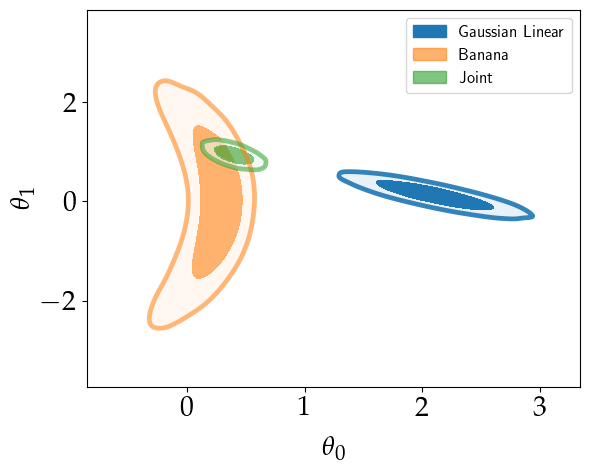

In [206]:
g = plots.get_single_plotter(width_inch=6, ratio=0.8)
g.settings.axes_fontsize = fontSize
g.settings.lab_fontsize = fontSize
g.settings.fontsize = fontSize
g.settings.solid_contour_palefactor = 0.9
g.settings.alpha_filled_add = 0.6
g.settings.alpha_factor_contour_lines = 0.9
g.settings.lw_contour = 2
g.plot_2d([samples_1, samples_2, samples_3], 'x0', 'x1', 
          filled=[True, True, True], 
          colors=[color1, color2, color3])
g.add_legend(['Gaussian Linear', 'Banana', 'Joint'], legend_loc='upper right');
plt.show()

## Normalizing Flow

In [220]:
class DataSet:

    def __init__(self, samples):
        
        self.ndim = samples.shape[1]
        self.samples = samples
        self.cov_train = np.cov(samples.T)
        self.cholesky = np.linalg.cholesky(self.cov_train)
        self.cholesky_inv = np.linalg.inv(self.cholesky)
        self.mean = np.mean(samples, axis = 0).reshape(-1, self.ndim)
        
    def forward(self, testpoint):
        testpoint = testpoint.reshape(-1, self.ndim)
        testtrans = self.cholesky_inv @ (testpoint - self.mean).T
        return testtrans.T

    def inverse(self, prediction):
        prediction = prediction.reshape(-1, self.ndim)
        predtrans = self.cholesky @ prediction.T + self.mean.T
        return predtrans.T
        
def create_dataset(samples, nsamples=None):
    mean_np = np.median(samples, axis = 0)
    std_np = np.std(samples, axis = 0)
    
    if nsamples is not None:
        nsamples_original = samples.shape[0]
        idx = random.sample(range(1, nsamples_original), nsamples)
        samples = samples[idx]
        
    dataset = torch.tensor(samples, dtype=torch.float)
    mean = torch.tensor(mean_np, dtype=torch.float)
    std = torch.tensor(std_np, dtype=torch.float)
    return dataset, mean, std

def build_network(hidden=(32, 32, 32)):
    """Creates a function to do the mapping

    Args:
        hidden (tuple, optional): Number of hidden layers. Defaults to (32, 32, 32).

    Returns:
        flowtorch.lazy.lazy: a composition of bijectors
    """

    transforms = bij.Compose(
        bijectors=[
            bij.AffineAutoregressive(
                params.DenseAutoregressive(hidden_dims=hidden, nonlinearity=nn.Tanh),
            ),
            bij.AffineAutoregressive(
                params.DenseAutoregressive(hidden_dims=hidden, nonlinearity=nn.Tanh),
            ),
            bij.AffineAutoregressive(
                params.DenseAutoregressive(hidden_dims=hidden, nonlinearity=nn.Tanh),
            ),
        ]
    )
    return transforms

def generate_banana_plot(generated_samples, target_samples, index):

    names = ["x%s"%i for i in range(ndim)]
    labels =  [r"$\theta_%s$"%i for i in range(ndim)]

    samples_2_generated = MCSamples(samples=generated_samples, names = names, labels = labels, settings = settings)
    samples_3_target = MCSamples(samples=target_samples, names = names, labels = labels, settings = settings)

    g = plots.get_single_plotter(width_inch=5, ratio=1.0)
    plt.suptitle(f'Iteration {index}', fontsize=fontSize)
    g.settings.axes_fontsize = fontSize
    g.settings.lab_fontsize = fontSize
    g.settings.fontsize = fontSize
    g.settings.solid_contour_palefactor = 0.9
    g.settings.alpha_filled_add = 0.6
    g.settings.alpha_factor_contour_lines = 0.9
    g.settings.lw_contour = 2
    g.plot_2d([samples_3_target, samples_2_generated], 'x0', 'x1', 
              filled=[True, False], 
              colors=[color2, color4],
             lws= [2, 3], lims=[-0.5, 1.0, -3.0, 3.0])
    g.add_legend(['Banana (target)',  'Banana (flow)'], legend_loc='upper right');
    os.makedirs('plots/banana/', exist_ok=True)
    plt.savefig(f'plots/banana/flow_{index}.png', bbox_inches = 'tight')
    plt.close()
    
class NormFlow(DataSet):
    def __init__(self, samples, nsamples=None, banana_sim: bool = False):

        
        DataSet.__init__(self, samples)
        data = DataSet.forward(self, samples)
        self.dataset, self.fiducial, self.std = create_dataset(data, nsamples)
        
        dist_x = torch.distributions.Independent(torch.distributions.Normal(self.fiducial, self.std), 1)
        bijector = build_network(hidden=(16, 16, 16))
        self.dist_y = dist.Flow(dist_x, bijector)
        self.banana_sim = banana_sim
        
    def training(self, lr=5E-3, nsteps = 1000, verbose = True):
        optimizer = torch.optim.Adam(self.dist_y.parameters(), lr=lr)
        record = []
        with tqdm.trange(nsteps, disable=not verbose) as bar:
            for step in bar:
                optimizer.zero_grad()
                loss = -self.dist_y.log_prob(self.dataset).mean()
                loss.backward()
                optimizer.step()
                record.append(loss.item())
                postfix = dict(Loss=f"{loss.item():.3f}")
                bar.set_postfix(postfix)
                if self.banana_sim and ((step+1)% 50 == 0):
                    gen_samples = self.generate_samples(10000)
                    generate_banana_plot(gen_samples, self.samples, step+1)
        return record
            
    def generate_samples(self, nsamples):
        gen_samples = self.dist_y.sample(torch.Size([nsamples,])).detach().numpy()
        gen_samples = DataSet.inverse(self, gen_samples)
        return gen_samples

    def loglike(self, parameter):
        parameter = DataSet.forward(self, parameter)
        p_tensor = torch.tensor(parameter, dtype=torch.float)
        return self.dist_y.log_prob(p_tensor).detach().numpy() + np.log(np.linalg.det(self.cholesky_inv))

In [221]:
gl_flow = NormFlow(samples_gl, nsamples=10000)
gl_flow_loss = gl_flow.training(lr=5e-3, nsteps=3000)
gl_flow_samples = gl_flow.generate_samples(nsamples*nwalkers)

100%|██████████████████████████████████████████████████████████████████| 3000/3000 [00:58<00:00, 51.58it/s, Loss=2.840]


In [222]:
banana_flow = NormFlow(samples_banana, nsamples=20000, banana_sim=False)
banana_flow_loss = banana_flow.training(lr=5e-3, nsteps=3000)
banana_flow_samples = banana_flow.generate_samples(nsamples*nwalkers)

100%|██████████████████████████████████████████████████████████████████| 3000/3000 [01:16<00:00, 39.36it/s, Loss=2.298]


In [223]:
samples_1_flow = MCSamples(samples=gl_flow_samples, names = names, labels = labels, settings = settings)
samples_2_flow = MCSamples(samples=banana_flow_samples, names = names, labels = labels, settings = settings)

Removed no burn in
Removed no burn in


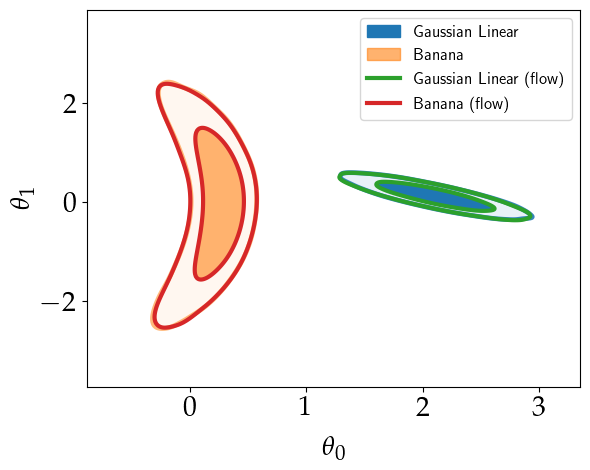

In [224]:
g = plots.get_single_plotter(width_inch=6, ratio=0.8)
g.settings.axes_fontsize = fontSize
g.settings.lab_fontsize = fontSize
g.settings.fontsize = fontSize
g.settings.solid_contour_palefactor = 0.9
g.settings.alpha_filled_add = 0.6
g.settings.alpha_factor_contour_lines = 0.9
g.settings.lw_contour = 2
g.plot_2d([samples_1, samples_2, samples_1_flow, samples_2_flow], 'x0', 'x1', 
          filled=[True, True, False, False], 
          colors=[color1, color2, color3, color4],
         lws= [2, 2, 3, 3])
g.add_legend(['Gaussian Linear', 'Banana', 'Gaussian Linear (flow)', 'Banana (flow)'], legend_loc='upper right');
# plt.savefig(f'plots/gl_banana.pdf', bbox_inches = 'tight')
plt.show()

In [225]:
def loglike_flows(sample, flows):
    nflow = len(flows)
    logl = sum([flows[i].loglike(sample) for i in range(nflow)])
    return logl
    
class SampleFlow:
    def __init__(self, flows: list):
        self.flows = flows
    
    def sampler(self, fiducial, nsamples, nwalkers = 4, eps = 1E-3):
        ndim = len(fiducial)
        pos = fiducial + eps * np.random.randn(nwalkers, ndim)
        nwalkers, ndim = pos.shape
        sampler = emcee.EnsembleSampler(nwalkers, ndim, loglike_flows, args=(self.flows,))
        sampler.run_mcmc(pos, nsamples, progress=True)
        return sampler

In [226]:
truth = 0.5 * (truth_gl + truth_bn)
joint_flow = SampleFlow([gl_flow, banana_flow])
sampler_flow = joint_flow.sampler(truth, nsamples)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:29<00:00, 66.87it/s]


In [227]:
samples_3_flow = MCSamples(samples=sampler_flow.flatchain, names = names, labels = labels, settings = settings)

Removed no burn in


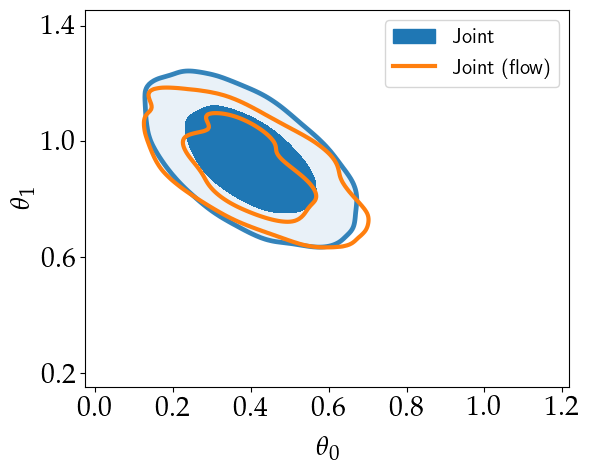

In [228]:
g = plots.get_single_plotter(width_inch=6, ratio=0.8)
g.settings.axes_fontsize = fontSize
g.settings.lab_fontsize = fontSize
g.settings.fontsize = fontSize
g.settings.solid_contour_palefactor = 0.9
g.settings.alpha_filled_add = 0.6
g.settings.alpha_factor_contour_lines = 0.9
g.settings.lw_contour = 2
g.settings.legend_fontsize = 15
g.plot_2d([samples_3, samples_3_flow], 'x0', 'x1', 
          filled=[True, False], 
          colors=[color1, color2], lws= [2,3])
g.add_legend(['Joint', 'Joint (flow)'], legend_loc='upper right');
# plt.savefig(f'plots/gl_banana_joint.pdf', bbox_inches = 'tight')
plt.show()

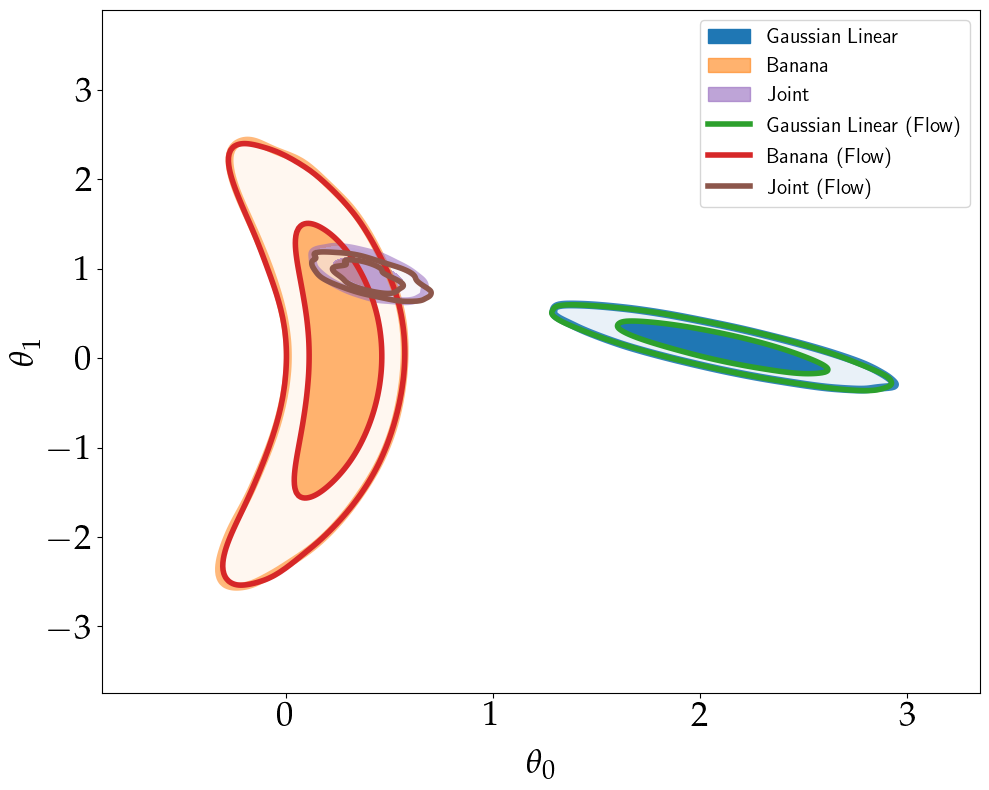

In [230]:
g = plots.get_single_plotter(width_inch=10, ratio=0.8)
g.settings.axes_fontsize = fontSize+5
g.settings.lab_fontsize = fontSize+5
g.settings.fontsize = fontSize+5
g.settings.solid_contour_palefactor = 0.9
g.settings.alpha_filled_add = 0.6
g.settings.alpha_factor_contour_lines = 0.9
g.settings.lw_contour = 2
g.settings.legend_fontsize = 15
g.plot_2d([samples_1, samples_2, samples_3, samples_1_flow, samples_2_flow, samples_3_flow], 'x0', 'x1', 
          filled=[True, True, True, False, False, False], 
          colors=[color1, color2, color5, color3, color4, color6],
          lws= [2, 2, 2, 4, 4, 4])
g.add_legend(['Gaussian Linear', 'Banana', 'Joint', 'Gaussian Linear (Flow)', 'Banana (Flow)', 'Joint (Flow)'], legend_loc='upper right');
# plt.savefig(f'plots/gl_banana_all_flows.pdf', bbox_inches = 'tight')
plt.show()

In [119]:
# import cv2
# import os

# image_folder = 'plots/banana/'
# video_name = 'plots/banana.avi'
# fps = 5

# images = [f'flow_{(i+1)*50}.png' for i in range(60)]
# frame = cv2.imread(os.path.join(image_folder, images[0]))
# height, width, layers = frame.shape

# video = cv2.VideoWriter(video_name, 0, fps, (width,height))

# for image in images:
#     video.write(cv2.imread(os.path.join(image_folder, image)))

# cv2.destroyAllWindows()
# video.release()

# Tutorial (1D)

In [39]:
import torch 
from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform
from torch.func import grad
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pylab as plt 
from typing import Any
import numpy as np 

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
fontSize = 15

In [83]:
distribution = Normal(0, 1)
unif_dist = Uniform(0, 1)
nsamples = 200

grad_cdf = grad(lambda x: distribution.cdf(x))
unif_samples = unif_dist.rsample(torch.Size([nsamples]))
norm_samples = distribution.icdf(unif_samples)
norm_pdf = torch.FloatTensor(list(map(grad_cdf, norm_samples)))

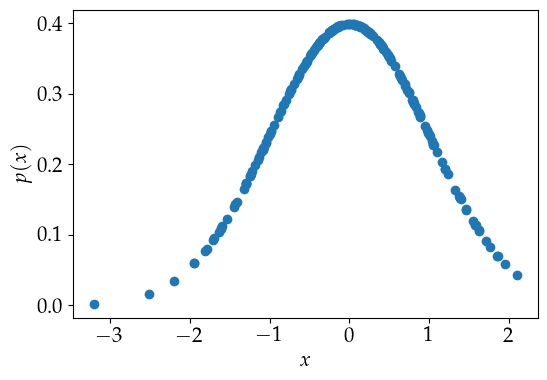

In [85]:
plt.figure(figsize = (6,4))
plt.scatter(norm_samples, norm_pdf)
plt.ylabel(r'$p(x)$', fontsize = fontSize)
plt.xlabel(r'$x$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSizse)
plt.tick_params(axis='y', labelsize=fontSize)
plt.show()

# Idea

Reference: https://github.com/TinyVolt/normalizing-flows/tree/main

The latent variable, $z$, can be written in terms of the cumulative density function, $\phi$ as: 

$$
z=\sum_{c}^{C}w_{c}\,\phi_{c}(x)
$$

and the derivative of $z$ with respect to $x$ is:

$$
\dfrac{d z}{d x} = \sum_{c}^{C}\,w_{c}\,\mathcal{N}(x|\mu_{c},\,\sigma^{2}_{c})
$$

The relation between $p(x)$ and $p(z)$ is: 

$$
\textrm{log}\,p(x) = \textrm{log}\,p(z)+\textrm{log}\,\left|\dfrac{d z}{d x}\right|
$$

In [40]:
class Flow1d(nn.Module):
    def __init__(self, n_components: int = 5):
        super(Flow1d, self).__init__()
        self.mus = nn.Parameter(torch.randn(n_components), requires_grad=True)
        self.log_sigmas = nn.Parameter(torch.zeros(n_components), requires_grad=True)
        self.weight_logits = nn.Parameter(torch.ones(n_components), requires_grad=True)

    def forward(self, point: torch.tensor):
        point = point.view(-1,1)
        weights = self.weight_logits.softmax(dim=0).view(1,-1)
        distribution = Normal(self.mus, self.log_sigmas.exp())
        latents = (distribution.cdf(point) * weights).sum(dim=1)
        dz_by_dx = (distribution.log_prob(point).exp() * weights).sum(dim=1)
        return latents, dz_by_dx

class NumpyDataset(Dataset):
    def __init__(self, array):
        super().__init__()
        self.array = array

    def __len__(self):
        return len(self.array)

    def __getitem__(self, index):
        return self.array[index]

def generate_mixture_of_gaussians(num_of_points: int):
    n = num_of_points // 3
    gaussian1 = np.random.normal(loc=-1, scale=0.25, size=(n,))
    gaussian2 = np.random.normal(loc=0.5, scale=0.5, size=(n,))
    gaussian3 = np.random.normal(loc=0.0, scale=0.1, size=(num_of_points - 2 * n,))
    return np.concatenate([gaussian1, gaussian2, gaussian3])

def loss_function(base_dist, latent: torch.tensor, dz_by_dx: torch.tensor) -> torch.tensor:
    log_likelihood = base_dist.log_prob(latent) + dz_by_dx.log()
    return -log_likelihood.mean()

def train(model, train_loader, optimizer, base_dist):
    model.train()
    for x in train_loader:
        latent, dz_by_dx = model(x)
        loss = loss_function(base_dist, latent, dz_by_dx)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
def eval_loss(model: Flow1d, data_loader: DataLoader, base_dist: Any) -> float:
    model.eval()
    total_loss = 0
    for x in data_loader:
        latent, dz_by_dx = model(x)
        loss = loss_function(base_dist, latent, dz_by_dx)
        total_loss += loss * x.size(0)
    return (total_loss / len(data_loader.dataset)).item()

def train_and_eval(epochs: int, lr: float, train_loader: DataLoader, test_loader: DataLoader, base_dist: Any, n_components: int = 5):
    flow = Flow1d(n_components)
    optimizer = torch.optim.Adam(flow.parameters(), lr=lr)
    train_losses, test_losses = [], []
    for epoch in range(epochs):
        train(flow, train_loader, optimizer, base_dist)
        train_losses.append(eval_loss(flow, train_loader, base_dist))
        test_losses.append(eval_loss(flow, test_loader, base_dist))
    return flow, train_losses, test_losses

In [50]:
n_train, n_test = 10000, 2000
train_data = generate_mixture_of_gaussians(n_train)
test_data = generate_mixture_of_gaussians(n_test)

train_loader = DataLoader(NumpyDataset(train_data), batch_size=128, shuffle=True)
test_loader = DataLoader(NumpyDataset(test_data), batch_size=128, shuffle=True)

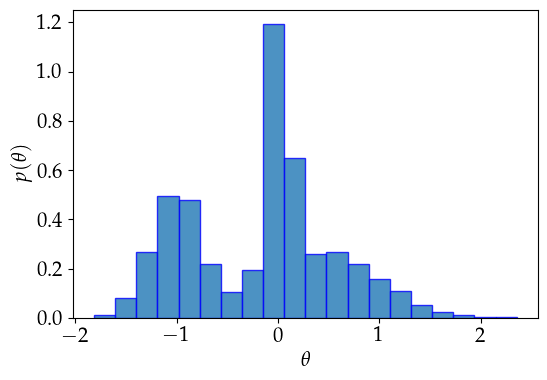

In [51]:
plt.figure(figsize=(6,4))
plt.hist(train_data, bins = 20, density = True, alpha=0.8, edgecolor='blue')
plt.ylabel(r'$p(\theta)$', fontsize = fontSize)
plt.xlabel(r'$\theta$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.show()

### Training

In [52]:
base_dist = Uniform(0.0, 1.0)
nepochs = 50
learning_rate = 5e-3
flow, train_losses, test_losses = train_and_eval(nepochs, 
                                                 learning_rate, 
                                                 train_loader, 
                                                 test_loader, 
                                                 base_dist,
                                                 n_components=5)

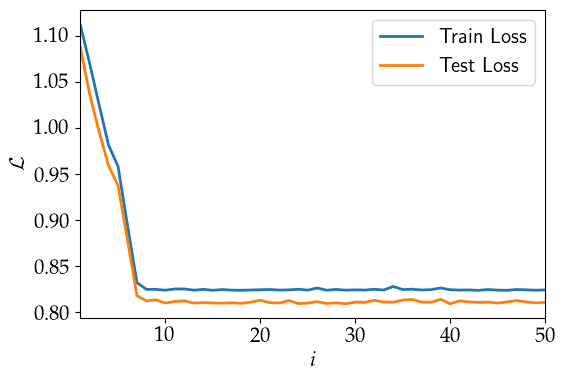

In [53]:
plt.figure(figsize=(6,4))
plt.plot(np.arange(nepochs) + 1.0, train_losses, lw=2, label = 'Train Loss')
plt.plot(np.arange(nepochs) + 1.0, test_losses, lw=2, label = 'Test Loss')
plt.ylabel(r'$\mathcal{L}$', fontsize = fontSize)
plt.xlabel(r'$i$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xlim(1, nepochs)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.show()

In [54]:
xtest = np.linspace(-3,3,1000)
with torch.no_grad():
    latents_test, dz_by_dx_test = flow(torch.FloatTensor(xtest))
    px_test = (base_dist.log_prob(latents_test) + dz_by_dx_test.log()).exp().cpu().numpy()

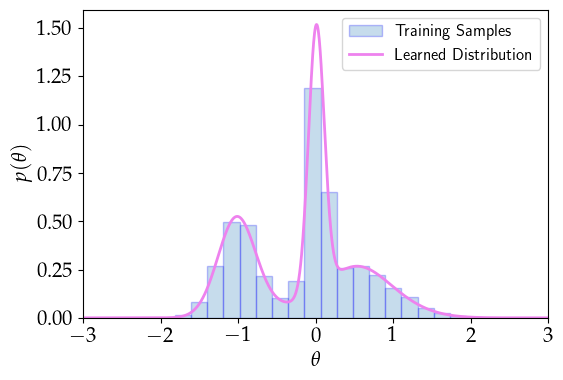

In [60]:
plt.figure(figsize=(6,4))
plt.hist(train_data, bins = 20, density = True, alpha=0.25, edgecolor='blue', label = 'Training Samples')
plt.plot(xtest, px_test, lw=2, c = 'violet', label = 'Learned Distribution')
plt.ylabel(r'$p(\theta)$', fontsize = fontSize)
plt.xlabel(r'$\theta$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xlim(min(xtest), max(xtest))
plt.legend(loc = 'upper right',prop={'family':'sans-serif', 'size':12})
# plt.savefig('plots/1D_mixture_gaussian.pdf', bbox_inches = 'tight')
plt.show()

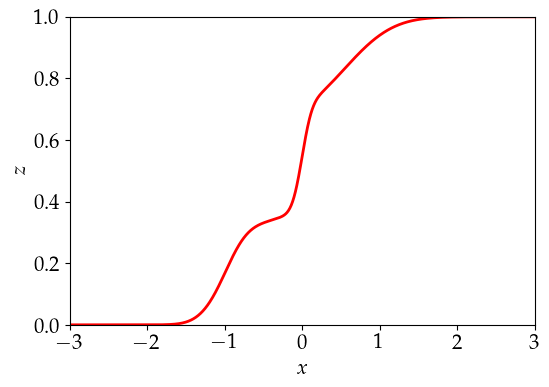

In [234]:
plt.figure(figsize=(6,4))
plt.plot(xtest, latents_test, lw=2, c = 'r')
plt.ylabel(r'$z$', fontsize = fontSize)
plt.xlabel(r'$x$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xlim(min(xtest), max(xtest))
plt.ylim(0, 1)
plt.show()

If we want to find $x$ given $z$, we need to resort to numerical method. 

In [235]:
from scipy.stats import norm
from scipy.optimize import bisect

def gmm_cdf(x, weights, means, std_devs):
    """CDF of a Gaussian Mixture Model."""
    cdf_value = 0.0
    for w, mu, sigma in zip(weights, means, std_devs):
        cdf_value += w * norm.cdf(x, mu, sigma)
    return cdf_value

def gmm_inverse_cdf(p, weights, means, std_devs, tol=1e-6):
    """Inverse CDF of a Gaussian Mixture Model using bisection method."""
    # Define the function for which we need to find the root
    def func(x):
        return gmm_cdf(x, weights, means, std_devs) - p

    return bisect(func, -3.0, 3.0, xtol=tol)

In [236]:
means = flow.mus.data.numpy()
std_devs = flow.log_sigmas.exp().data.numpy()
weights = flow.weight_logits.softmax(dim=0).data.numpy()

In [237]:
# Probability for which we want to find the inverse CDF
p = np.random.uniform(0, 1)

# Calculate the inverse CDF
x = gmm_inverse_cdf(p, weights, means, std_devs)
print(f"The value of x such that the CDF is {p:.3f} is approximately {x:.3f}.")

The value of x such that the CDF is 0.955 is approximately 1.090.
